In [1]:
from models.model import Model
from data_loader import Dataset
from tqdm import tqdm
from utils import *

import os
import random
import argparse
import yaml
from typing import Dict, Tuple, List, Any, Union, Optional

import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import timedelta

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# Baseline Data Loader

주어진 Baseline DataLoader와 임베딩된 벡터를 분석합니다.

In [2]:
config_path = "./config.yaml"

with open(config_path, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
dataset = Dataset(cfg['Dataset'])

In [4]:
dataset.prepare_train_data()

전처리된 파일이 존재합니다. 전처리 파일 불러오는 중...완료.

----------------------------------------------------------------------------------------------------



대부분의 값은 0을 갖는데, 매우 큰 값을 갖는 데이터도 존재합니다.
차원은 데이터수 * in_features * channels 에 해당합니다.

In [5]:
print(dataset.train_X[0])
print(dataset.train_X.shape)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.4070e+03, 1.1770e+03,
         5.8600e+02],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.1157e-01, 8.1157e-01,
         8.1157e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
torch.Size([3611, 9, 128])


Plot을 시켜보면 대부분의 값이 0으로 존재하는 데 반해, 특정 차원의 값만 상당히 값이 큰 것으로 나타납니다.

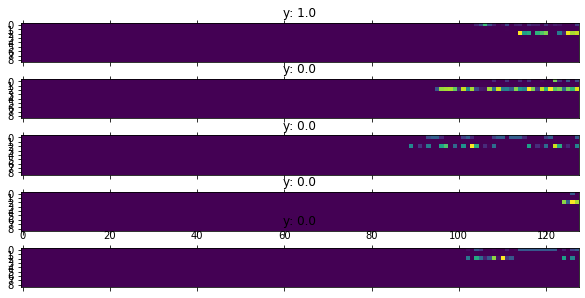

In [6]:
len_dataset = dataset.train_X.size(0)
num_graphs = 5
selected_ids = random.choices(range(len_dataset), k=num_graphs)

fig, ax = plt.subplots(num_graphs, 1, sharex=True, figsize=(10, num_graphs))
for i, idx in enumerate(selected_ids):
    ax[i].matshow(dataset.train_X[idx].detach().cpu().numpy())
    ax[i].set_title("y: {}".format(dataset.train_y[idx].item()))
plt.show()
# in_features * channels

따라서 `np.log1p()`를 취해야 좋지 않을까 생각합니다. 그러나 1을 더해주더라도 음수 혹은 0 값이 존재하는 경우가 있어서 이를 해결할 필요가 있어 보입니다. 그리고 분명한  것은 데이터 중에서 값이 존재하지 않는 구간이 상당히 존재한다는 것입니다. 모두 0값을 갖는 범위까지도 삽입이 되어야 하는 지를 판단할 필요가 있어 보입니다.

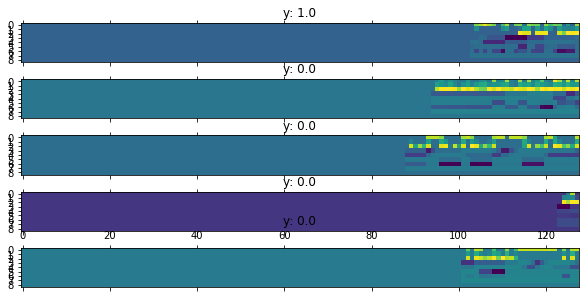

In [7]:
# len_dataset = dataset.train_X.size(0)
# num_graphs = 5
# selected_ids = random.choices(range(len_dataset), k=num_graphs)

fig, ax = plt.subplots(num_graphs, 1, sharex=True, figsize=(10, num_graphs))
for i, idx in enumerate(selected_ids):
    ax[i].matshow(np.log1p(dataset.train_X[idx].detach().cpu().numpy()))
    ax[i].set_title("y: {}".format(dataset.train_y[idx].item()))
    # 생각보다 일정한 구간이 짧음...
plt.show()
# in_features * channels

# Data EDA

데이터를 불러와서 임베딩하는 과정을 살펴보면 아래와 같습니다. 일단, csv 파일 형태로 된 login 데이터와 push 데이터를 불러옵니다. login 데이터는 어떤 유저가 어떤 게임에 언제 로그인 했는가를 보여줍니다. 아래에서 `push_logs`라는 dictionary는 `game_id`를 key로 갖고 해당하는 `pd.DataFrame`을 value로 갖습니다. 

In [8]:
login_log_path = "data/login_logs/sample.csv"
push_log_path  = "data/push.csv"

login_logs = pd.read_csv(login_log_path) # login logs from a certain game (given with game_id)
push_logs = pd.read_csv(push_log_path)

login_logs.inDate = pd.to_datetime(login_logs.inDate.apply(lambda x: x[:-1])) + timedelta(hours=9)
push_logs.pushTime = pd.to_datetime(push_logs.pushTime.apply(lambda x: x[:-1])) # Already KST
push_logs = {game_id: x.sort_values(by='pushTime') for game_id, x in push_logs.groupby('game_id')}
# Dict[str, pd.DataFrame]

In [9]:
login_logs.head()

,gamer_id,game_id,inDate
0,gamer_9234,1442,2021-07-01 09:00:54.174
1,gamer_9234,1442,2021-07-01 09:01:02.105
2,gamer_8506,2147,2021-07-01 09:01:15.138
3,gamer_1599,1046,2021-07-01 09:03:27.895
4,gamer_7833,1482,2021-07-01 09:06:04.362


In [10]:
for k, v in push_logs.items():
    print(k)
    print(v)
    break

1007
      Unnamed: 0            pushTime game_id
1969        1970 2020-03-17 02:00:00    1007
4002        4004 2020-03-17 02:00:00    1007
5355        5357 2020-03-17 02:30:00    1007


`pd.to_datetime()`을 이용해 시간형태로 분리해주었기 때문에, `max()`와 `min()` 값을 뽑아낼 수 있습니다.

In [11]:
total_max_date = login_logs.inDate.max()
total_min_date = login_logs.inDate.min()
print("Dataset span: from {} // to {}".format(total_min_date, total_max_date))

Dataset span: from 2021-07-01 09:00:54.174000 // to 2021-10-13 10:46:01.542000


이를 이용해 정해진 time step만큼 (아래에서는 5일) 등간격으로 날짜를 나눠줍니다. 아래의 날짜 범위를 이용해 데이터를 생성합니다.

In [12]:
point_date_count = (total_max_date - total_min_date).days // 5
point_dates = [(total_max_date - timedelta(days=7 + 5 * i)).replace(hour=6, minute=0, second=0, microsecond=0) for i in range(1, point_date_count + 1)]
point_dates
# creates the interval

[Timestamp('2021-10-01 06:00:00'),
 Timestamp('2021-09-26 06:00:00'),
 Timestamp('2021-09-21 06:00:00'),
 Timestamp('2021-09-16 06:00:00'),
 Timestamp('2021-09-11 06:00:00'),
 Timestamp('2021-09-06 06:00:00'),
 Timestamp('2021-09-01 06:00:00'),
 Timestamp('2021-08-27 06:00:00'),
 Timestamp('2021-08-22 06:00:00'),
 Timestamp('2021-08-17 06:00:00'),
 Timestamp('2021-08-12 06:00:00'),
 Timestamp('2021-08-07 06:00:00'),
 Timestamp('2021-08-02 06:00:00'),
 Timestamp('2021-07-28 06:00:00'),
 Timestamp('2021-07-23 06:00:00'),
 Timestamp('2021-07-18 06:00:00'),
 Timestamp('2021-07-13 06:00:00'),
 Timestamp('2021-07-08 06:00:00'),
 Timestamp('2021-07-03 06:00:00'),
 Timestamp('2021-06-28 06:00:00')]

`prepared_gamer_id`를 저장하고, `prepared_counts`라는 `defaultdict`을 이용해 유저별로 최대 `3`개의 데이터만을 추출해냅니다.

아래의 코드에서 함수를 정의할 때 모두 type hint를 병기했습니다.

In [13]:
prepared_gamer_id = set()
prepared_counts = defaultdict(lambda: 3)
data = []
test_data = []
errors = []

In [14]:
def daily_embedding(x):
    # unit is hour in [0, 24)
    return np.stack([np.sin(2 * np.pi / 24 * x), np.cos(2 * np.pi / 24 * x)])

def weekly_embedding(x):
    # unit is dayofweek in [0, 6]
    return np.stack([np.sin(2 * np.pi / 7 * x), np.cos(2 * np.pi / 7 * x)])

def transform(
    inDate: pd.Series, 
    cut_length: int = 0
):
    """
    Args:
        inDate: pd.Series of pd.datetime64
    Returns:
        X: torch.FloatTensor
    """
    # X is inDate(pandas datetime64 Series).
    
    # 요일과 접속 시간대를 삼각함수로 임베딩
    day_of_week = np.array(inDate.dt.dayofweek) # (N,)
    hour_of_day = np.array(inDate.dt.hour + inDate.dt.minute / 60)
    embedding_D = daily_embedding(hour_of_day) # (2, N)
    embedding_W = weekly_embedding(day_of_week)

    in_date = np.array(inDate).astype('datetime64') # (N,)

    # 접속 간격 계산
    # datetime 타입을 numerical type으로 casting하면 micro second로 계산됨
    interval = (in_date[1:] - in_date[:-1]).astype('float') / 1000000 # (N - 1,)
    interval = np.array([0, *(interval.tolist())]) # (N,)
    interval_D = interval // (3600 * 24)
    interval_H = (interval % (3600 * 24)) // 3600
    interval_S = interval % 3600

    interval = np.stack([interval_D, interval_H, interval_S]) # (3, N)
    out = torch.from_numpy(np.concatenate([interval, embedding_W, embedding_D], axis=0)) # (7, N)
    # inDate transformed to
    # [interval_D, interval_H, interval_S, 
    #  embedding_W_sine, embedding_D_cosine, 
    #  embedding_D_sine, embedding_D_cosine]

    if cut_length:
        _out = torch.zeros((x.shape[0], cut_length))
        if cut_length > out.shape[1]:
            _out[:, -out.shape[1]:] = out
        else: # cut_length <= x.shape[1]
            _out[:] = out[:, -cut_length:]
        out = _out

    return out

def extract_sample(
    login_logs: pd.DataFrame, 
    push_logs: Dict[str, pd.DataFrame], # Dict[game_id, push_time]
    point_date: pd.Timestamp, 
    date_range: Optional[Tuple[pd.Timestamp, pd.Timestamp]] = None,
):
    cut_length = 128

    if date_range is None:
        date_range = (login_logs.inDate.min(), login_logs.inDate.max())
    
    in_date = login_logs.inDate
    in_date = in_date.sort_values()

    game_id = login_logs.game_id.iloc[0]
    game_id = str(game_id)
    push_time = push_logs[game_id].pushTime if game_id in push_logs.keys() else None

    total_login_count = len(in_date)
    
    y = get_label(point_date, in_date)
    # Whether a user is loggined from D+1 to D+7 (future data)

    input_in_date = in_date[in_date <= point_date]
    if push_time is not None:
        
        push_time = push_time[(push_time >= date_range[0]) & (push_time <= point_date)]
        # get push times only within D-14 ~ D-day
        input_in_date = np.concatenate([input_in_date, push_time])

        log_type = np.zeros((len(input_in_date) + len(push_time), 2))
        log_type[:len(input_in_date), 0] = 1
        log_type[len(input_in_date):, 1] = 1

        args = np.argsort(input_in_date)
        input_in_date = pd.Series(input_in_date[args])
        log_type = log_type[args]
    
    else:
        # push_time can be None if the game hasn't sent any push!
        log_type = np.zeros((len(input_in_date), 2))
        log_type[:, 0] = 1

    log_type = np.concatenate([np.zeros((cut_length, 2)), log_type], axis=0)[-cut_length:]
    # add padding to the front
    # shape of log_type: cut_length * 2

    x = transform(input_in_date, cut_length)
    x = torch.cat([x, torch.from_numpy(log_type).T], dim=0)
    sample = (x, total_login_count, y, game_id)

    return sample


In [15]:
def get_label(
    point_date: pd.Timestamp, 
    in_date: pd.Series,
):
    d1 = point_date + timedelta(days=1)
    d7 = point_date + timedelta(days=7)
    y = ((in_date > d1) & (in_date < d7)).sum() > 0
    # whether a user logins within D+1 ~ D+7
    return [y]

In [16]:
for point_date in point_dates:
    min_date = point_date - timedelta(days=14)
    max_date = point_date + timedelta(days=7)
    sliced_logs = login_logs[(login_logs.inDate >= min_date) & (login_logs.inDate <= max_date)]
    print("min_date: {}, point_date: {}, max_date: {}".format(min_date, point_date, max_date))
    print("length of sliced logs: {} of {}".format(len(sliced_logs), len(login_logs)))
    # point_date를 기준으로 D-14 ~ D-day를 input으로 활용 -> User Feature
    # D+1 ~ D+7은 레이블링에 활용 -> T & Y

    for gamer_id, X in sliced_logs.groupby('gamer_id'):
        if gamer_id in prepared_gamer_id:
            if prepared_counts[gamer_id] > 0:
                prepared_counts[gamer_id] -= 1
                continue
        
        # 문제가 있는 gamer_id는 데이터로 활용하지 않는다.
        if len(X.game_id.unique()) > 1:
            errors.append({'game_id': X.game_id.unique().tolist(), 'gamer_id': gamer_id, 'length': len(X)})
        
        # 로그가 너무 적은 gamer_id는 데이터로 활용하지 않는다.
        if len(X) < 5: continue

        # 기준일 이전에 로그가 없으면 판단 불가
        if X.inDate.min() >= point_date: continue

        print(gamer_id)
        print("length of X:", len(X))
        print(X.head())

        sample = extract_sample(
            X, 
            push_logs, 
            point_date, 
            (min_date, max_date),
        )
        break

    break

min_date: 2021-09-17 06:00:00, point_date: 2021-10-01 06:00:00, max_date: 2021-10-08 06:00:00
length of sliced logs: 47458 of 189985
gamer_1006
length of X: 33
          gamer_id  game_id                  inDate
130808  gamer_1006     2364 2021-09-17 09:56:12.681
130809  gamer_1006     2364 2021-09-17 09:56:16.030
131560  gamer_1006     2364 2021-09-17 18:03:35.720
131561  gamer_1006     2364 2021-09-17 18:03:40.718
132335  gamer_1006     2364 2021-09-17 21:17:38.797


In [17]:
sample
# X, total_login_count, y, 2364

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+03,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.0711e-01, 7.0711e-01,
          7.0711e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]], dtype=torch.float64),
 33,
 [False],
 '2364')